<a name="top"></a>
# Predicting Subreddits through Comments

## Preprocessing and Modeling
---
* [Importing Libraries](#importinglibraries)
* [Summary and Visualization](#DataCleaning)
  * [Bar Graph](#bargraph)
  * [Word Cloud](#wordcloud)
  * [Venn Diagram](#venndiagram)
* [Constructing Model](#executivesummary)
  * [Naive Bayes](#bargraph)
  * [GridSearch](#wordcloud)
* [Model Evaluation](#DataAcquisition)  

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud, ImageColorGenerator
from sklearn.feature_extraction import text
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokens import Doc
from nltk.corpus import stopwords
import re

warnings.filterwarnings('ignore')
sns.set_style('ticks')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline
pd.set_option('display.max_colwidth',1000)

In [2]:
comments = pd.read_csv('../data/comments.csv')
singapore = pd.read_csv('../data/singapore.csv')
uk = pd.read_csv('../data/uk.csv')

In [3]:
# further preprocessing
regex_html = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
singapore['body'].replace(regex=True,inplace=True, to_replace=regex_html,value=r'')
uk['body'].replace(regex=True,inplace=True, to_replace=regex_html,value=r'')
comments['body'].replace(regex=True,inplace=True, to_replace=regex_html,value=r'')

### Summary and Visualization

This allows us to visualize the top 50 words posted in both subreddits. It is very interesting that covid 19 is the top phrase used in the singapore subreddit by quite a margin. This is quite understandable given the situation we are in now. In addition to that, other phrases such as "source code" or "source code contribute" is an indication that the discussions in the singapore subreddit is heavily tech based. "Circuit breaker" is another commonly used phrase which is exclusive to Singapore as the government termed our lockdown as a "circuit breaker".
As for the UK, although covid related phrases are amongst the top phrases used in the subreddit comments, it is quite interesting that their top phrase is "dont know". It is hard to come up with a reason as to why that is the case but it is interesting nonetheless. One of the top few phrases used in the UK is "furlough scheme" and it is no surprise given that this is a policy exclusive to the UK during the Covid period which allows employers to stand down workers but then claim a cash grant of up to 80% of their wages.

In addition, through the aid of a venn diagram, based on the top 50 words in both subreddits, it is quite surprising that there are so many words (excluding stop words) that are unique to Singapore and the UK. This demonstrates how far both countries have diverged in terms of the language used since the British colonised Singapore. The average number of word lengths for both the singapore and united kingdom are about 39 and 45 words respectively while in terms of mean scoring for a particular post, singapore slightly edges the uk with a mean score of 2.68 compared to the UK's 1.83.


In [55]:
singapore.describe()

,created_utc,score,word_length
count,8.250000e+02,825.000000,825.000000
mean,1.589340e+09,2.689697,39.858182
std,5.549735e+03,5.147881,64.158504
min,1.589328e+09,-35.000000,5.000000
25%,1.589335e+09,1.000000,11.000000
50%,1.589340e+09,1.000000,21.000000
75%,1.589344e+09,3.000000,43.000000
max,1.589349e+09,42.000000,646.000000


In [56]:
uk.describe()

,created_utc,score,word_length
count,8.850000e+02,885.000000,885.000000
mean,1.589328e+09,1.830508,45.715254
std,9.017881e+03,3.669702,70.981964
min,1.589316e+09,-23.000000,5.000000
25%,1.589321e+09,1.000000,14.000000
50%,1.589326e+09,1.000000,27.000000
75%,1.589333e+09,3.000000,52.000000
max,1.589350e+09,28.000000,1250.000000


In [4]:
cvec = CountVectorizer(stop_words = ENGLISH_STOP_WORDS, ngram_range=(2,3))

In [5]:
# upon inital inspection, there were many words that came up amongst the top 50 words
# they do not have any significance and therefore, included in the stop words list which
# I merged with the ENGLISH_STOP_WORDS
my_stop_words = text.ENGLISH_STOP_WORDS.union(["gt",'amp','nbsp'])

cvec = CountVectorizer(ngram_range=(2,3), stop_words=my_stop_words)

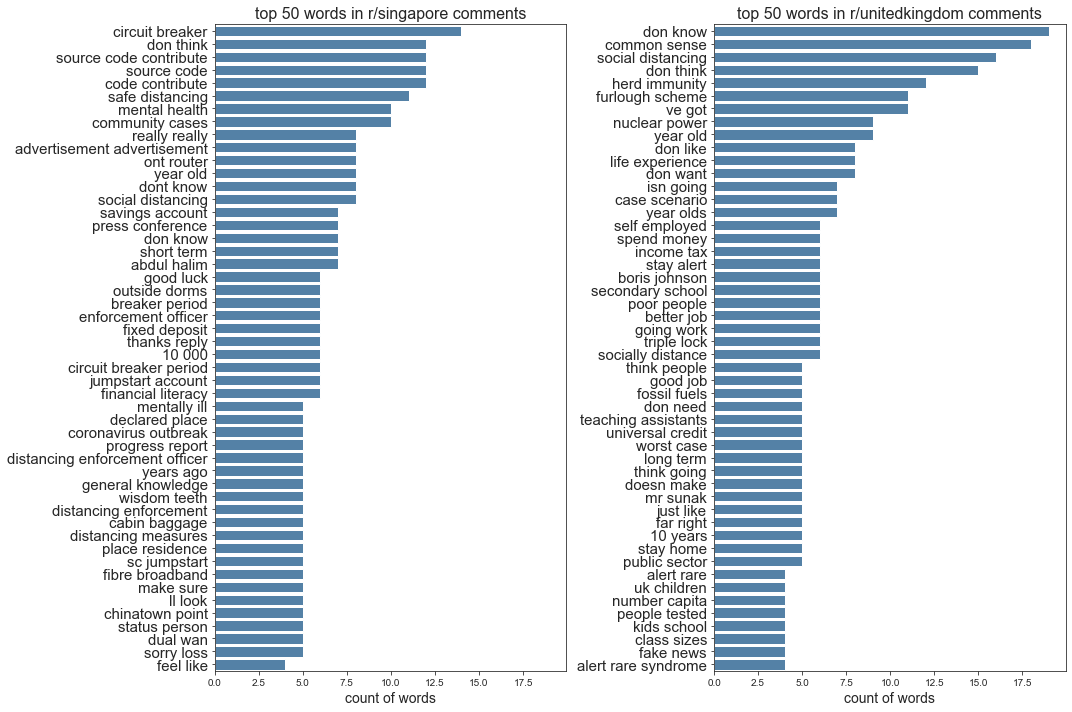

In [51]:

# r/Singapore - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_sg = cvec.fit_transform(singapore['body'])
vec_sg = pd.DataFrame(vec_sg.toarray(), columns = cvec.get_feature_names())
sg_comments_50 = vec_sg.sum().sort_values(ascending=False).head(50)

# r/UnitedKingdom - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_uk = cvec.fit_transform(uk['body'])
vec_uk = pd.DataFrame(vec_uk.toarray(), columns = cvec.get_feature_names())
uk_comments_50 = vec_uk.sum().sort_values(ascending=False).head(50)

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=sg_comments_50.index.values, x = sg_comments_50,color='steelblue',ax=ax[0])
ax[0].set_title('top 50 words in r/singapore comments',fontsize=16)
ax[0].set_xlabel('count of words', fontsize=14)
plt.setp(ax[0].get_yticklabels(), fontsize=15)

sns.barplot(y=uk_comments_50.index.values, x = uk_comments_50,color='steelblue',ax=ax[1])
ax[1].set_title('top 50 words in r/unitedkingdom comments',fontsize=16)
ax[1].set_xlabel('count of words', fontsize=14)
plt.setp(ax[1].get_yticklabels(), fontsize=15)

plt.tight_layout()

plt.savefig("../images/top50words.png")



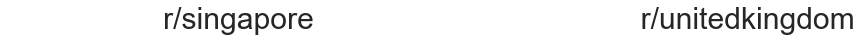

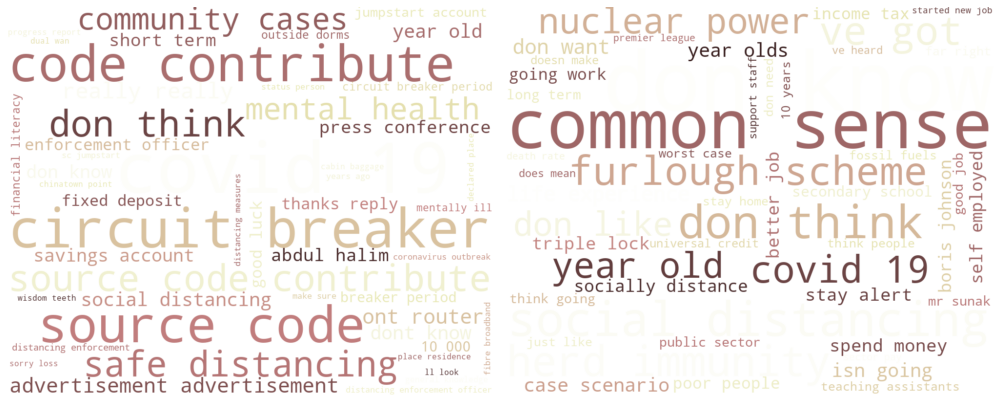

In [49]:
# set up WordCloud
wc_sg = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='white',
                  colormap='pink').generate_from_frequencies(sg_comments_50) 

wc_uk = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='white',
                  colormap='pink').generate_from_frequencies(uk_comments_50) 

plt.figure(figsize=(8, 0.3))
plt.text(x = 0.35,                              
         y = 0.9,                             
         s = 'r/singapore                                       r/unitedkingdom', 
         ha = 'left',                        
         va = 'center',                       
         size = 30)                         
plt.axis('off')

# plot the WordCloud image 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 7))
ax[0].imshow(wc_sg, interpolation='bilinear')
ax[0].axis('off')
ax[1].imshow(wc_uk, interpolation='bilinear')
ax[1].axis('off')
plt.tight_layout()

plt.savefig("../images/wordcloud.png")



In [8]:
print(comments.info())
comments.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710 entries, 0 to 1709
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   body         1710 non-null   object
 1   created_utc  1710 non-null   int64 
 2   id           1710 non-null   object
 3   parent_id    1710 non-null   object
 4   score        1710 non-null   int64 
 5   subreddit    1710 non-null   object
 6   word_length  1710 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 93.6+ KB
None


,body,created_utc,id,parent_id,score,subreddit,word_length
0,Thanks for the advice! Ill try to open it as soon as I can,1589349005,fqgkuus,t1_fqgimf5,1,singapore,14
1,Sometimes it will only feel wet or damp when the source of the water damage is occurring such as when it rains or when your above neighbour uses their water for an extended period of time (washing/showering etc). Anyway keep monitoring it and once you see water dripping down call HDB straight away. My home kena 2 incidents of ceiling leaking water cos my neighbour's lousy contractor did a bad job with their water pipes.,1589348893,fqgkpqx,t1_fqgk00m,2,singapore,75
2,"21M, sounds like you’re in uni. How are you doing right now financially? If you are able to get through life right now without financial difficulty, I would put 40% into savings (for rainy days) and 60% into a robo-investment account, or pump it into low risk investments.",1589348878,fqgkp1x,t3_giq3ox,1,singapore,48
3,Nick and Amy's r/s so bloody toxic sia,1589348871,fqgkoqt,t1_fqggm9a,2,singapore,8
4,"no probs! Okay so my method is using a disposable mask place mask on nose bridge and plaster the wire to the nose bridge...like wearing a pore pack. stretch it to the bottom of the chin and plaster the mask below your jaw, like when u got cut there, horizontally so that's the top and bottom of your hexagon. all you need to do is to tape one from the bridge of your nose towards below your ear (both sides). finally, one last plaster to connect them to form your hexagon you might want to cut off the straps before doing it. good luck!!!",1589348846,fqgkno5,t1_fqgk18a,2,singapore,104


In [9]:
comments['subreddit'].value_counts()

unitedkingdom    885
singapore        825
Name: subreddit, dtype: int64

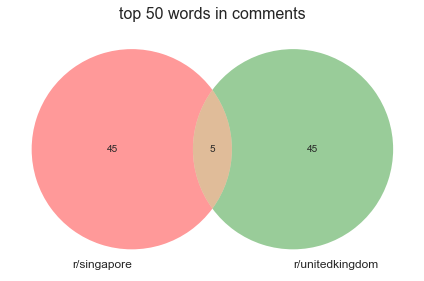

In [10]:
venn2([set(sg_comments_50.index), set(uk_comments_50.index)], set_labels = ('r/singapore','r/unitedkingdom'))
plt.title('top 50 words in comments', fontsize=16)
plt.tight_layout()


###  Constructing Model

Before anything else, in order to analyse textual data, one must be able to prepare it for predictive modeling. The text must be parsed to remove words through a process called **tokenization**. After which, the words have to be encoded as integers or floating point values in order to be used as an input to a machine learning algorithm called **vectorization**(feature extraction). 


**Bag of words:**
It is a way of extracting features from text to use in modeling. A bag-of-words represents text that describes occurence of words within a document which consists of the vocabulary of the known words and it is a measure of presence of known words. There is no information about the order or structure of words. Model concerns itself with whether the known words occur in the document, or not. In essence we break the words into units **(tokenization)**, count the number of times they appear in each comment and then create a vector for each comment which is the number of times each word appears. 

There are two main vectorizers in particular that allows us to convert textual data into numerical data in order to model. **CountVectorizer()** and **TFIDVectorizer()** which are the most commonly used. The former tokenizes and counts while the TFID goes one step further by normalizing the frequencies. In essence, the TFID Vectorizer will reduce the weight of words that tend to appear in a lot of the comments while applying more weight to the words that do not appear as much in the corpus. The rationale behind this is so that the rarer words have more predictive power.

**Hyperparameters:**
Ideally, we want to do this while excluding words such as "the" "and" "that" which would dominate the frequencies and lower the predictive power of the model. These are called **"stop words"** which is a standard exclusion lists built into the vectorizers. 
Another useful parameter in the bag of words appraoch is to consider **n-grams** where the model could be run into different grams of words instead of just one word. **Vocabulary Size** is also particular useful as a parameter as it allows us to control for the most popular words, least popular words in the entire corpus.

In [11]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710 entries, 0 to 1709
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   body         1710 non-null   object
 1   created_utc  1710 non-null   int64 
 2   id           1710 non-null   object
 3   parent_id    1710 non-null   object
 4   score        1710 non-null   int64 
 5   subreddit    1710 non-null   object
 6   word_length  1710 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 93.6+ KB


In [12]:
comments['subreddit'].value_counts()

unitedkingdom    885
singapore        825
Name: subreddit, dtype: int64

#### Engineer a feature to turn `subreddit`  into a 1 or 0 column 

In [13]:
# singapore takes the value of "1" and the uk takes the value of "0"
comments.subreddit.replace(('singapore', 'unitedkingdom'), (1, 0), inplace=True)

#### Check for unbalanced classes

In [45]:
# seens to be fairly well distributed
# prior probs of positive and negative classes
comments['subreddit'].value_counts(normalize=True)

0    0.517544
1    0.482456
Name: subreddit, dtype: float64

### CountVectorizer( ) and Naive Bayes:

#### Split data into `X` and `y`

In [15]:
X = comments[['body']]
y = comments['subreddit']

#### Train-Test-Split

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(1368, 1)
(1368,)
(342, 1)
(342,)


#### `Count Vectorization` 

In [17]:
# stop words - remove words that are frequently used and less informative in terms of which
# subreddit it belongs to

# considering the period we are in, I have added other stop words into the default list
# that do not offer higher predictive value
my_stop_words = text.ENGLISH_STOP_WORDS.union(['covid 19','covid','corona virus'
                                               ,'virus','social distancing','lockdown',
                                               'quarantine','gt','amp','nbsp'])



In [18]:
# Instantiate a CountVectorizer
cvec = CountVectorizer(ngram_range=(2,3), stop_words=my_stop_words)

In [19]:
# fit CountVectorizer on training data and transform training data
# always do it with respect to training data
# it returns as a sparse matrix so convert to a data frame
# to dense/to array, changed into a matrix
# text features get converted

X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['body']).todense(),
                           columns = cvec.get_feature_names())

In [20]:
# transform validation (testing) data with the already fit CountVectorizer
X_val_cvec = pd.DataFrame(cvec.transform(X_val['body']).todense(),
                         columns = cvec.get_feature_names())

#### Fit model - Naive Bayes

There are three types of Naive Bayes models. BernoulliNB, MultinomialNB and finally GaussianNB. We want to fit a multinomialNB here as the experiments here have multiple outcomes.

In [21]:
# instantiate model 

nb = MultinomialNB()

In [22]:
# fit model
model = nb.fit(X_train_cvec, y_train)

In [23]:
# generate predictions
predictions = model.predict(X_val_cvec)

In [24]:
# evaluate model
# score model on the training set
model.score(X_train_cvec, y_train)

0.9963450292397661

In [25]:
# score model on the test set
model.score(X_val_cvec, y_val)

0.6842105263157895

Model is extremely overfitted. There are few ways to work around this. 
Try to collect more data, attempting to use fewer features by setting `max_features` to a smaller number, or perhaps even use another model altogether.

### TFIDVectorizer( ) and Naive Bayes:

#### `TFID Vectorization`


In [29]:
# Instantiate a TF-IDF vectorizer
tvec = TfidfVectorizer(ngram_range=(2,3), stop_words=my_stop_words)

In [30]:
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train['body']).toarray(),
                           columns = tvec.get_feature_names())

In [31]:
X_val_tvec = pd.DataFrame(tvec.transform(X_val['body']).todense(),
                         columns = tvec.get_feature_names())

#### Fit model - Naive Bayes

In [32]:
# instantiate model 
nb = MultinomialNB()

# fit model
model = nb.fit(X_train_tvec, y_train)

# generate predictions
predictions = model.predict(X_val_tvec)

# evaluate model
# score model on the training set
print(model.score(X_train_tvec, y_train))

# score model on the test set
model.score(X_val_tvec, y_val)

0.9963450292397661


0.695906432748538

Attempted to use the TFID Vectorization. As mentioned earlier, this will give different weights to different words within the corpus depending on how often it appears. It seems that the model did not change much in terms of accuracy and is still very heavily overfitted.

### `GridSearch` : CountVectorizer( ) and Logistic Regression

As our model performed fairly poorly earlier, GridSearchCV was employed to get better accuracy of the results. 

In [36]:
X = comments['body']
y = comments['subreddit']

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(1368,)
(1368,)
(342,)
(342,)


In [35]:
from sklearn.pipeline import Pipeline

In [38]:
#Creates pipeline to handle vectorization and logistic regression steps
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('model', LogisticRegression())
     ])

#Specifies different hyperparameter values that we want to test across
params = {
    'vect__ngram_range':[(1,3)],
    'vect__min_df':[2,5],
    'vect__stop_words':[None,'my_stop_words'],
    'model__penalty':['l2','l1'],
    'model__C':[0.1, 1, 10],
}

#Executes GridSearch
gs = GridSearchCV(pipe, params, cv=10)
gs.fit(X_train, y_train)


print('train accuracy:', gs.score(X_train, y_train))
print('validation set accuracy:', gs.score(X_val, y_val))
print(gs.best_params_)

train accuracy: 0.9992690058479532
validation set accuracy: 0.7690058479532164
{'model__C': 1, 'model__penalty': 'l2', 'vect__min_df': 2, 'vect__ngram_range': (1, 3), 'vect__stop_words': None}


### `GridSearch` : TFIDVectorizer( ) and Logistic Regression

In [39]:
pipe2 = Pipeline([
    ('vect', TfidfVectorizer()),
    ('model', LogisticRegression())
     ])

params = {
    'vect__ngram_range':[(1,3)],
    'vect__min_df':[2,5],
    'vect__stop_words':[None,'my_stop_words'],
    'model__penalty':['l2','l1'],
    'model__C':[0.1, 1, 10],
}

gs2 = GridSearchCV(pipe2, params, cv=10)
gs2.fit(X_train, y_train)

print('train accuracy:', gs2.score(X_train, y_train))
print('validation set accuracy:', gs2.score(X_val, y_val))
print(gs2.best_params_)

train accuracy: 1.0
validation set accuracy: 0.8070175438596491
{'model__C': 10, 'model__penalty': 'l2', 'vect__min_df': 2, 'vect__ngram_range': (1, 3), 'vect__stop_words': None}


### Model Evaluation

It seems like Logistic Regression performed much better than the Naive Bayes model with an accuracy above **75%** for both the CountVectorization and the TFIDVectorization. As baseline model was around **50%** for both classes, this represents a significant improvement. However, having said that, the model is still overfitted. The model that produced the best result is **GridSearch using TFIDVectorizer() and Logistic Regression.**.

**Confusion Matrix:**
Another way to evaluate the performance of a classfier is to look at the confusion matrix. The idea is to count number of times a class (r/singapore) is classified as another class (r/unitedkingdom) and vice versa.  In order to compute confusion matrix, one has to have a set of predictions which can be compared to the actual targets. Each row in a confusion matrix represents the actual class while each column represents the predicted classes. 

In [40]:
# singapore } 1 and uk } 0
# 30 corresponds to false positive (type 1 error) - the model wrongly predicted comment to 
# be in postive class (singapore) when it was in the negative class (singapore)

# 36 corresponds to false negative (type 2 error) - the model wrongly predicted comment to 
# be in the negative class (uk) when it was actually in the positive class (singapore)

prediction = gs2.predict(X_val)
confusion_matrix(y_val, # True values.
                 prediction)  # Predicted values.

array([[147,  30],
       [ 36, 129]])

In [43]:
def customised_confusion_matrix(y_val, prediction):
    
    c_matrix = confusion_matrix(y_val, prediction)
    
    return pd.DataFrame(c_matrix, columns =['Predicted ' + str(i) for i in ['UK','Singapore']],\
            index=['Actual ' + str(i) for i in ['UK','Singapore']])

customised_confusion_matrix(y_val, prediction)

,Predicted UK,Predicted Singapore
Actual UK,147,30
Actual Singapore,36,129


The **confusion matrix** gives a lot of information but it would be helpful to get a more concise metric. For instance, one could get the accuracy of the positive predictions. This could be calculated by the **precision**. This metric is usually used alongside **sensitivy/recall (true positive rate)**, which, in essence is the ration of positive instances that are correctly detected by the classifier. Finally it is also common practice to combine both **Precision** and **Recall** into a common metric called the **F1 Score**. It is a harmonic mean of precision and recall. As a result, the classifier will only get a high **F1 Score** if both precision and recall are high.

**Precision**: True positives/(True posistives + False positives)

**Recall/Sensitivity**: True positives/(True Positives + False Negatives)

**F1 Score**: 2/((1/precision) + (1/recall))

In [42]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(f'Accuracy: {accuracy_score(y_val, prediction)}')
print(classification_report(y_val, prediction))


Accuracy: 0.8070175438596491
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       177
           1       0.81      0.78      0.80       165

    accuracy                           0.81       342
   macro avg       0.81      0.81      0.81       342
weighted avg       0.81      0.81      0.81       342



### Conclusion

Despite the limitations of overfitting, the model still has some value. This approach could be
used for other applications in NLP. In terms of of similarities between two countries, one could point to the fact that both the UK and Singapore are going through the Covid 19 period so a lot of the language used in these posts will be quite similar (even after excluding for stopwords) or perhaps day to day discussions do not vary as much between countries. They might differ in terms of their politics or current affairs in their respective countries.

In order to improve the accuracy of the model, a larger corpus which incorporates a much wider range of vocabulary could prove to be helpful.